<a href="https://colab.research.google.com/github/NULabTMN/ps2-Connor-Frazier/blob/development/SequencePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence Prediction: Surname Generation

In this experiment, you will explore a simple sequence prediction task: Text generation using a Gated Recurrent Unit (GRU). Like the LSTM, this is a  gated recurrent neural network, but since it has fewer parameters, it should be more appropriate for a smaller dataset.

The GRU computes a probability distribution over the set of possible characters in the surname vocabulary for each time step. We use these probability distributions to generate new surnames. You are given a starter code, that trains a SurnameGenerationModel on the [surname dataset](https://github.com/jasoriya/CS6120-PS2-support/blob/master/data/surnames/surnames_with_splits.csv) to generate new surnames by learning from the training data. 



Your task is to understand this code and plot the over all perplxity of GRU model as a function of the hidden representation size (K) and the number of characters already observed. You will see **TODO** prompts in the following cells

## Imports

In [0]:
import os
from argparse import Namespace

import numpy as np
import httpimport
import torch
import torch.optim as optim
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import pandas as pd

#Used below to mount google drive for save directory path
# from google.colab import drive
# drive.mount('/content/gdrive')

# import data preprocessing and modeling functions from https://github.com/jasoriya/CS6120-PS2-support/tree/master/utils
with httpimport.remote_repo(['data_vectorization','model','helper'], 'https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/utils/'):
  from data_vectorization import Vocabulary, SequenceVocabulary, SurnameVectorizer, SurnameDataset, generate_batches
  from model import SurnameGenerationModel, sample_from_model, decode_samples
  from helper import make_train_state, update_train_state, normalize_sizes, compute_accuracy, sequence_loss, set_seed_everywhere, handle_dirs


### Settings and some prep work

**TODO**: 
- Give path to a directory where the model should be saved
- Give hidden state size (`rnn_hidden_size`) for the GRU model (experiment with different levels)


In [2]:
args = Namespace(
    # Data and Path information
    surname_csv="https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir= "gdrive/My Drive/", # give path here
    # Model hyper parameters
    char_embedding_size=32,
    rnn_hidden_size= 64, # give hidden size, started at 16
    # Training hyper parameters
    seed=1337,
    learning_rate=0.001,
    batch_size=128,####
    num_epochs=100,
    early_stopping_criteria=5,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	gdrive/My Drive/vectorizer.json
	gdrive/My Drive/model.pth
Using CUDA: True


### Initializations

In [0]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

model = SurnameGenerationModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vectorizer.char_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)


### Training loop

In [4]:
mask_index = vectorizer.char_vocab.mask_index

model = model.to(args.device)


optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)
dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = model(x_in=batch_dict['x_data'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)


            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss,
                                  acc=running_acc,
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = model(x_in=batch_dict['x_data'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # Update bar
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=model, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break
        
        # move model to cpu for sampling
        model = model.cpu()
        sampled_surnames = decode_samples(
            sample_from_model(model, vectorizer, num_samples=2), 
            vectorizer)
        epoch_bar.set_postfix(sample1=sampled_surnames[0], 
                              sample2=sampled_surnames[1])
        # move model back to whichever device it should be on
        model = model.to(args.device)
        
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
        
except KeyboardInterrupt:
    print("Exiting loop")

In [5]:
np.random.choice(np.arange(len(vectorizer.nationality_vocab)), replace=True, size=2)

array([8, 7])

In [0]:
# compute the loss & accuracy on the test set using the best available model

model.load_state_dict(torch.load(train_state['model_filename']))

model = model.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_acc = 0
running_loss = 0
model.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    
    # compute the output
    y_pred = model(x_in=batch_dict['x_data'])

    # compute the loss
    loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)
    
    running_loss += (loss.item() - running_loss) / (batch_index + 1)
  
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss 
train_state['test_acc'] = running_acc 

**TODO**: Write code to compute the perplexity of the whole text corpus, the accuracy of a character-prediction task, and the perplexity at a given character position (1, 2, 3, ...).

In [7]:

#test perplexity
test_perplexity = 2**train_state['test_loss']  

print("Test loss: {};".format(train_state['test_loss']))
print("Test perplexity: {};".format(test_perplexity)) # compute and print perplexity here
print("Test Accuracy: {}".format(train_state['test_acc']))

"""Calculate average accuracies and perplexities for all indicies over the entire test set"""
#Gather the test set surnames and the longest word length in the test set
max_word_len = 0
test_surnames = []
csv = pd.read_csv(args.surname_csv)
for index, row in csv.iterrows():
    if row['split'] == 'test':
      test_surnames.append(row['surname'])
      if len(row['surname']) > max_word_len:
        max_word_len = len(row['surname'])
      
#Lists for record keeping
index_perplexity_sums = [0 for i in range(max_word_len)]
index_perplexity_counts = [0 for i in range(max_word_len)]
index_accuracy_sums = [0 for i in range(max_word_len)]
index_accuracy_counts = [0 for i in range(max_word_len)]

#Loop trhough all the names in the test set
for name in test_surnames:
  #Create array with token indices for each character in the current name
  indices = [vectorizer.char_vocab.begin_seq_index] 
  indices.extend(vectorizer.char_vocab.lookup_token(token) for token in name)
  indices.append(vectorizer.char_vocab.end_seq_index)

  #Make a prediciton for each character index in the current name
  for i in range(len(name)):
    #Create initial x and y vectors
    x = np.empty(len(name) + 1, dtype=np.int64)
    y = np.empty(len(name) + 1, dtype=np.int64)
  
    #Create x tensor for the ith character
    x_indices = indices[:-(len(name) + 1 - i)]
    x[:len(x_indices)] = x_indices
    x[len(x_indices):] = vectorizer.char_vocab.mask_index  
    x = torch.tensor([x], device=args.device)
  
    #Get the prediction from the model with the current x tensor
    prediction = model(x_in=x)
  
    #Create y tensor for the ith character
    y_indices = indices[1:(i+2)]
    y_indices.append(vectorizer.char_vocab.end_seq_index)
    y[:len(y_indices)] = y_indices
    y[len(y_indices):] = vectorizer.char_vocab.mask_index
    y = torch.tensor([y], device=args.device)

    #Calculate accuracy for the ith character
    acc = compute_accuracy(prediction, y, mask_index)
    
    #Record data
    index_accuracy_sums[i] += acc
    index_accuracy_counts[i] += 1

    #Calculate loss for the ith character
    loss = sequence_loss(prediction, y, mask_index)
    loss_number = loss.item()
  
    #Calculate the perplexity for the ith character
    perplexity = 2**loss_number
    
    #Record data
    index_perplexity_sums[i] += perplexity
    index_perplexity_counts[i] += 1

#Calculate the average character index accuracy and perplexity
index_accuracy_averages = [0 for i in range(max_word_len)]
index_perplexity_averages = [0 for i in range(max_word_len)]

for i in range(max_word_len):
  index_accuracy_averages[i] = index_accuracy_sums[i] / index_accuracy_counts[i]
  index_perplexity_averages[i] = index_perplexity_sums[i] / index_perplexity_counts[i]



Test loss: 2.4371257424354553;
Test perplexity: 5.41561711007573;
Test Accuracy: 27.90954373763542


## Inference
To see the names that the model generates:

In [8]:
# number of names to generate
num_names = 10
model = model.cpu()
sampled_surnames = decode_samples(
    sample_from_model(model, vectorizer, num_samples=num_names), 
    vectorizer)

print(len(sampled_surnames))
# Show results
print ("-"*15)
for i in range(num_names):
    print (sampled_surnames[i])

10
---------------
Korin
Icros
Awana
Skerdsin
Dahnis
Tilg
Pellaev
Riwen
Gyuhad
Culberto


**TODO**: Train the GRU model given above multiple times for different levels of `rnn_hidden_size`. For each of these models, plot the average perplexity as a function of the number of characters of the name observed so far. Explain your observations.

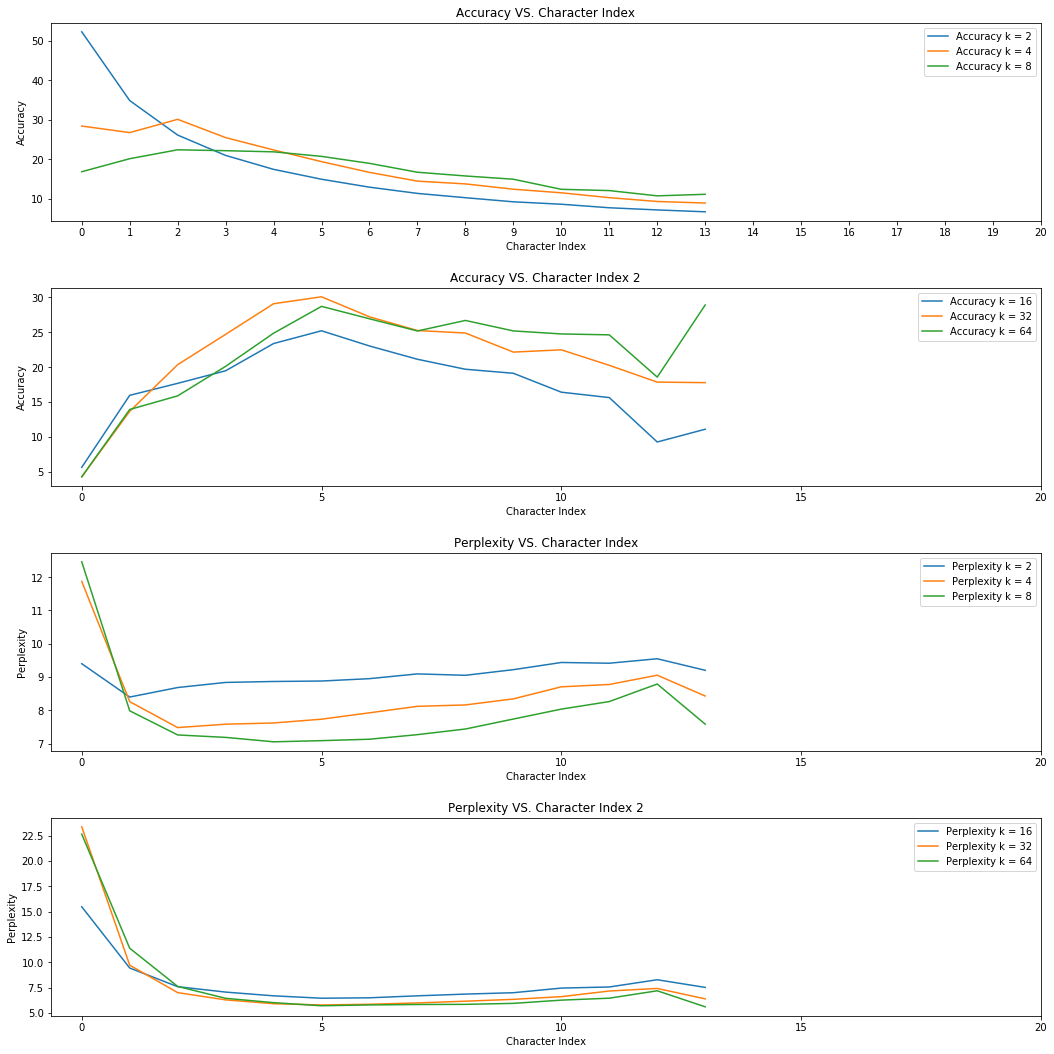

In [9]:
# Your plotting code here

"""The recorderd data for hidden_rnn_size = 2, 4, 8, 16, 32, 64"""

k2_accuracies = [52.34939759036145, 34.899598393575026, 26.139125151883352, 20.975, 17.439745338790644, 14.929107589657866, 12.915676959619953, 11.334961334961463, 10.24390243902439, 9.201101928374635, 8.585858585858581, 7.692307692307687, 7.142857142857141, 6.666666666666667]
k4_accuracies = [28.433734939759034, 26.767068273092548, 30.133657351154312, 25.5, 22.362437471578147, 19.397116644822855, 16.671615201900238, 14.448514448514583, 13.75, 12.396694214876012, 11.48989898989899, 10.256410256410252, 9.285714285714283, 8.88888888888889]
k8_accuracies = [16.837349397590362, 20.14056224899586, 22.402794653705953, 22.175, 21.884947703501666, 20.731562015965476, 18.957838479809975, 16.707366707366827, 15.762195121951219, 14.931129476584, 12.373737373737372, 12.051282051282046, 10.714285714285712, 11.111111111111112]
k16_accuracies = [5.662650602409639, 15.963855421686642, 17.679222357229648, 19.475, 23.37426102773989, 25.1995710711304, 23.025534441805224, 21.123321123321297, 19.695121951219512, 19.118457300275477, 16.41414141414142, 15.64102564102564, 9.285714285714283, 11.111111111111112]
k32_accuracies = [4.307228915662651, 13.674698795180662, 20.352369380315917, 24.6875, 29.07003183265123, 30.060764923150014, 27.197149643705462, 25.234025234025452, 24.878048780487806, 22.148760330578504, 22.474747474747474, 20.256410256410252, 17.857142857142854, 17.77777777777778]
k64_accuracies = [4.307228915662651, 13.935742971887482, 15.886998784933171, 20.1125, 24.852205547976354, 28.690575479566014, 26.915083135391924, 25.17297517297537, 26.676829268292682, 25.179063360881567, 24.74747474747475, 24.61538461538462, 18.571428571428566, 28.88888888888889]

k2_perplexity = [9.402114234086088, 8.40001172816427, 8.685885535294247, 8.839263323787213, 8.867819695415983, 8.881199014680107, 8.952682838544074, 9.09554625887192, 9.053430400779018, 9.222411123413144, 9.438375404138345, 9.41612302902145, 9.55026240944353, 9.203840436999998]
k4_perplexity = [11.873854110817026, 8.262722679065181, 7.482913316926316, 7.58478425907849, 7.621175544037211, 7.735425895712919, 7.926639766728447, 8.121562728140637, 8.163210736133001, 8.345179438918509, 8.70754511724805, 8.777731253318425, 9.056242506294332, 8.431225261690821]
k8_perplexity = [12.462404375470774, 7.986996063286865, 7.2619340002367245, 7.188517038183721, 7.0560418785454, 7.090512229033919, 7.133303180838415, 7.271216727718264, 7.440193727990158, 7.739694840167098, 8.037391847631296, 8.264721628070317, 8.791596642269612, 7.586216277429576]
k16_perplexity = [15.48115582435773, 9.43732401907229, 7.595424622922445, 7.062072266127846, 6.692276000576281, 6.456837247503778, 6.499272512073023, 6.693546596893835, 6.863594457572101, 7.00061314173073, 7.457165759461085, 7.56624379927665, 8.28054725185749, 7.524892744869742]
k32_perplexity = [23.374543500445615, 9.717808617455791, 7.009146030085884, 6.294128753581898, 5.916930618301128, 5.789589476000539, 5.862179446724023, 5.990646546504146, 6.163566587457043, 6.346616520064328, 6.612382203519056, 7.166702837747355, 7.422342383659924, 6.3918597130466]
k64_perplexity = [22.65385711883097, 11.38763106976892, 7.621538852725991, 6.448411260862909, 6.020546137397779, 5.711831891311322, 5.794164489743802, 5.838008812295406, 5.851511424002029, 5.94888038435698, 6.267671136904797, 6.460597335241798, 7.1912164856426255, 5.610276058840817]


"""Plot the character accuracy and perplexity over the character indices"""
x_axis_indices = []
for i in range(max_word_len):
  x_axis_indices.append(i)

plt.figure(figsize=(15,15))
plt.subplot(411)
plt.title('Accuracy VS. Character Index')
accuracies_line_k2 = plt.plot(x_axis_indices, k2_accuracies, label="Accuracy k = 2")
accuracies_line_k4 = plt.plot(x_axis_indices, k4_accuracies, label="Accuracy k = 4")
accuracies_line_k8 = plt.plot(x_axis_indices, k8_accuracies, label="Accuracy k = 8")
plt.xticks(np.arange(min(x_axis_indices), max(x_indices) - 1, 1.0))
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Character Index')

plt.subplot(412)
plt.title('Accuracy VS. Character Index 2')
accuracies_line_k16 = plt.plot(x_axis_indices, k16_accuracies, label="Accuracy k = 16")
accuracies_line_k32 = plt.plot(x_axis_indices, k32_accuracies, label="Accuracy k = 32")
accuracies_line_k64 = plt.plot(x_axis_indices, k64_accuracies, label="Accuracy k = 64")
plt.xticks(np.arange(min(x_axis_indices), max(x_indices) - 1, 5.0))
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Character Index')

plt.subplot(413)
plt.title('Perplexity VS. Character Index')
perplexity_line_k2 = plt.plot(x_axis_indices, k2_perplexity, label="Perplexity k = 2")
perplexity_line_k4 = plt.plot(x_axis_indices, k4_perplexity, label="Perplexity k = 4")
perplexity_line_k8 = plt.plot(x_axis_indices, k8_perplexity, label="Perplexity k = 8")
plt.xticks(np.arange(min(x_axis_indices), max(x_indices) - 1, 5.0))
plt.legend()
plt.ylabel('Perplexity')
plt.xlabel('Character Index')

plt.subplot(414)
plt.title('Perplexity VS. Character Index 2')
perplexity_line_k16 = plt.plot(x_axis_indices, k16_perplexity, label="Perplexity k = 16")
perplexity_line_k32 = plt.plot(x_axis_indices, k32_perplexity, label="Perplexity k = 32")
perplexity_line_k64 = plt.plot(x_axis_indices, k64_perplexity, label="Perplexity k = 64")
plt.xticks(np.arange(min(x_axis_indices), max(x_indices) - 1, 5.0))
plt.legend()
plt.ylabel('Perplexity')
plt.xlabel('Character Index')

plt.tight_layout(pad=2.0)
plt.show()

Implementation:

The test set perplexity is calcualted by raising 2 to the power of the test loss.

To get the average perplexity at each character index over the entire test set; first the test set words are gathered into a single list. Then for each word, an x vector and y vector are created for every character in the word. The model is used to make each prediction for every character in the word, and the associated accuracy, loss, and perplexity are calculated for the chracter index. To get the average perplexity and accuracy at each character index, the respective sum of perplexities and accuracies of predictions at the ith character are divided by the number of predictions at made at the ith character.

The graphs are created from multiple runs of the model with different values of hidden_rnn_size. The accuracies and perplexities were saved manually in lists to then be graphed after all of the runs. The graphs have 14 characters of context because the longest surname in the test set is 14 characters long.


Observations:

Accuracy:
The accuracy did not increase with the hidden_rnn_size as expected. I thought that the accuracy would increase for all characters as the hidden state size grew but that was not the case. As the hidden state size gets smaller, the accuracy of predictions with little to no context increases while the accuracy of predictions with more context decreseases. As the hidden state size gets larger, the accuracy of predictions with little to no context decreases while the accuracy of predictions with more context increases.

Perplexity:
The perplexity data was as expected. Generally, the perplexity at each character index did decrease as the context increased for all values of hidden_rnn_size. As the hidden_rnn_size increased the rate of decrease in perplexity increased, and the perplexity values at higher contexts were also smaller verall. One odd finding is that with lower hidden_rnn_size values, the perplexity at higher context levels starts to slightly increase.

With these results, it is apparent that the hidden state representation size is very important when modeling character level predictions. The hidden state size appears to control the ability to abilty to make predictions at certain amounts of contexts provided in the word. Smaller hidden state size models do best in the begining the of the word while bigger hidden state size models do better in the middle or at the end of a word. This suggests that for practical uses like text autocomplete it may be best to use to a model with a small hidden state size for character contexts of less than three and another model with a bigger hidden state size for larger amounts of context. Based off these results there appears to be no one hidden state size that is best for all amounts of context preovided.


